# Training Transformer

### TA's Slide
[Slide](https://docs.google.com/presentation/d/1ga0d43mWyrfHjdkp7FG3iWcEKTGr8CdkifYhhi4LBY8/edit?usp=sharing)

### Description
In this assignment, we are tasked with utilizing a transformer decoder-only architecture for pretraining, with a focus on next-token prediction, applied to Pokémon images.

Please feel free to mail us if you have any questions.

ntu-ml-2025-spring-ta@googlegroups.com

# Utilities

### Download packages

In [1]:
!pip install datasets==3.3.2

### Import Packages

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoModelForCausalLM, GPT2Config, set_seed, Qwen2Model, Qwen2Config
from datasets import load_dataset
from typing import Dict, Any, Optional

### Check Devices

In [3]:
!nvidia-smi

Sat Apr 12 15:35:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Set Random Seed

In [4]:
# 讓code可以reproduce
set_seed(0)

# Prepare Data

### Define Dataset

In [5]:
from typing import List, Tuple, Union
import torch
from torch.utils.data import Dataset

# 建dataset的path
class PixelSequenceDataset(Dataset):
    def __init__(self, data: List[List[int]], mode: str = "train"):
        """
        A dataset class for handling pixel sequences.

        Args:
            data (List[List[int]]): A list of sequences, where each sequence is a list of integers.
            mode (str): The mode of operation, either "train", "dev", or "test".
                - "train": Returns (input_ids, labels) where input_ids are sequence[:-1] and labels are sequence[1:].
                - "dev": Returns (input_ids, labels) where input_ids are sequence[:-160] and labels are sequence[-160:].
                - "test": Returns only input_ids, as labels are not available.
        """
        self.data = data
        self.mode = mode

    def __len__(self) -> int:
        """Returns the total number of sequences in the dataset."""
        return len(self.data)

    def __getitem__(self, idx: int) -> Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        """
        Fetches a sequence from the dataset and processes it based on the mode.

        Args:
            idx (int): The index of the sequence.

        Returns:
            - If mode == "train": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "dev": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "test": torch.Tensor -> input_ids
        每個sequence都代表一張圖片，一串pixel

        """
        sequence = self.data[idx]

        if self.mode == "train":
            # input是除了最後一個token的sequence
            input_ids = torch.tensor(sequence[:-1], dtype=torch.long)
            # label是除了第一個token的sequence
            labels = torch.tensor(sequence[1:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "dev":
            # 前面60%的sequence
            input_ids = torch.tensor(sequence[:-160], dtype=torch.long)
            # 後面40%的sequence
            labels = torch.tensor(sequence[-160:], dtype=torch.long)
            return input_ids, labels
        # 只有inputs
        elif self.mode == "test":
            input_ids = torch.tensor(sequence, dtype=torch.long)
            return input_ids

        raise ValueError(f"Invalid mode: {self.mode}. Choose from 'train', 'dev', or 'test'.")

### Download Dataset & Prepare Dataloader

In [6]:
# Load the pokemon dataset from Hugging Face Hub
pokemon_dataset = load_dataset("lca0503/ml2025-hw4-pokemon")

# Load the colormap from Hugging Face Hub
colormap = list(load_dataset("lca0503/ml2025-hw4-colormap")["train"]["color"])

# Define number of classes
num_classes = len(colormap)
print(num_classes)

# Define batch size
batch_size = 16


# === Prepare Dataset and DataLoader for Training ===
train_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["train"]["pixel_color"], mode="train"
)
train_dataloader: DataLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# === Prepare Dataset and DataLoader for Validation ===
dev_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["dev"]["pixel_color"], mode="dev"
)
dev_dataloader: DataLoader = DataLoader(
    dev_dataset, batch_size=batch_size, shuffle=False
)

# === Prepare Dataset and DataLoader for Testing ===
test_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["test"]["pixel_color"], mode="test"
)
test_dataloader: DataLoader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


167


### Visualization

In [7]:
# 可以看training/testing(每張圖都只有60%部分) sets裡面圖片的長相
def pixel_to_image(pixel_color: List[int], colormap: List[List[int]]) -> Image.Image:
    """
    Converts a list of pixel indices into a 20x20 RGB image using a colormap.

    Args:
        pixel_color (List[int]): A list of pixel indices representing colors.
        colormap (List[List[int]]): A list where each index maps to an RGB color [R, G, B].

    Returns:
        Image.Image: A PIL Image object representing the reconstructed image.
    """
    # Ensure the pixel_color list has at least 400 elements (pad with 0s if needed)
    while len(pixel_color) < 400:
        pixel_color.append(0)

    # Map pixel indices to actual RGB colors using the colormap
    pixel_data = [colormap[pixel] for pixel in pixel_color]

    # Convert to numpy array and reshape to 20x20x3 (RGB image)
    image_array = np.array(pixel_data, dtype=np.uint8).reshape(20, 20, 3)

    # Create a PIL Image from the array
    image = Image.fromarray(image_array)

    return image

def show_images(images: List[Image.Image]) -> None:
    """
    Displays a grid of up to 96 images using Matplotlib.

    Args:
        images (List[Image.Image]): A list of PIL Image objects to display.

    Returns:
        None
    """
    num_images = min(96, len(images))  # Limit to 96 images

    # Set up the figure size and grid layout (6 rows, 16 columns)
    fig, axes = plt.subplots(6, 16, figsize=(16, 6))
    axes = axes.flatten()  # Flatten to make iteration easier

    # Loop through images and display each one in the grid
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')  # Hide axis
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

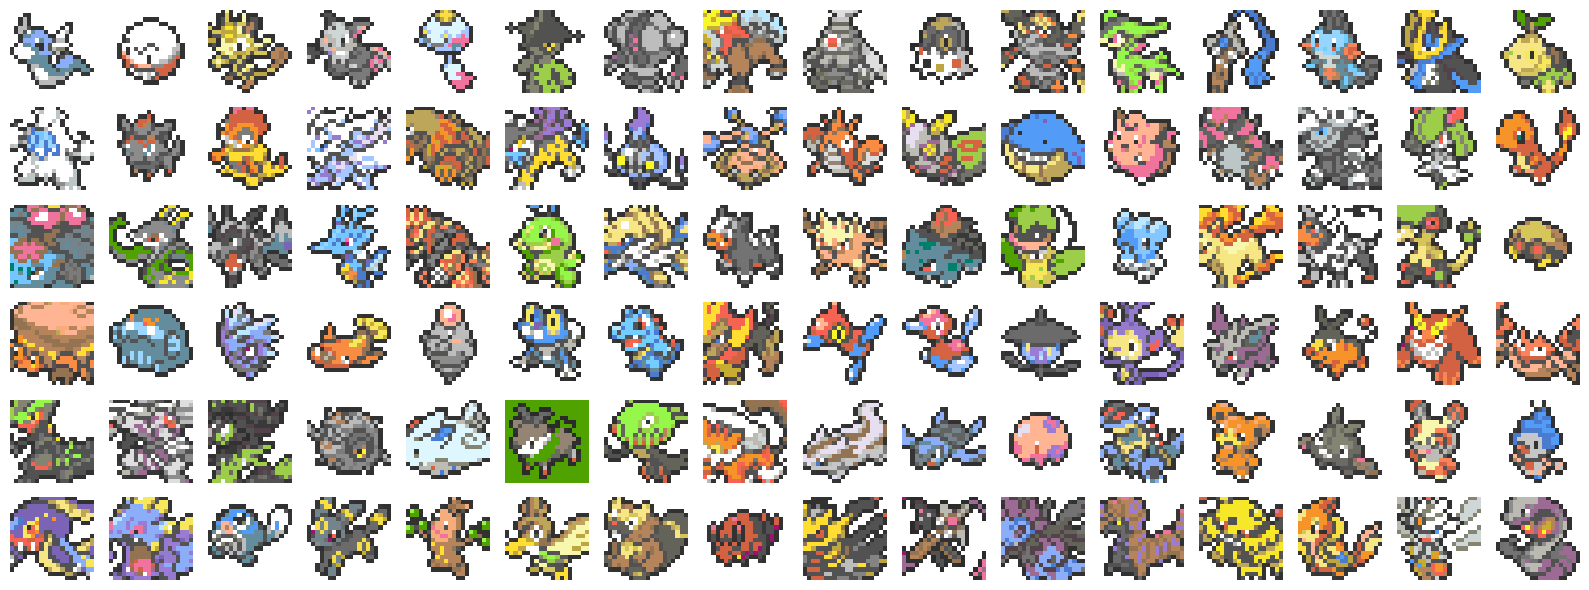

In [8]:
# Visualize train images
train_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["train"]]
show_images(train_images)

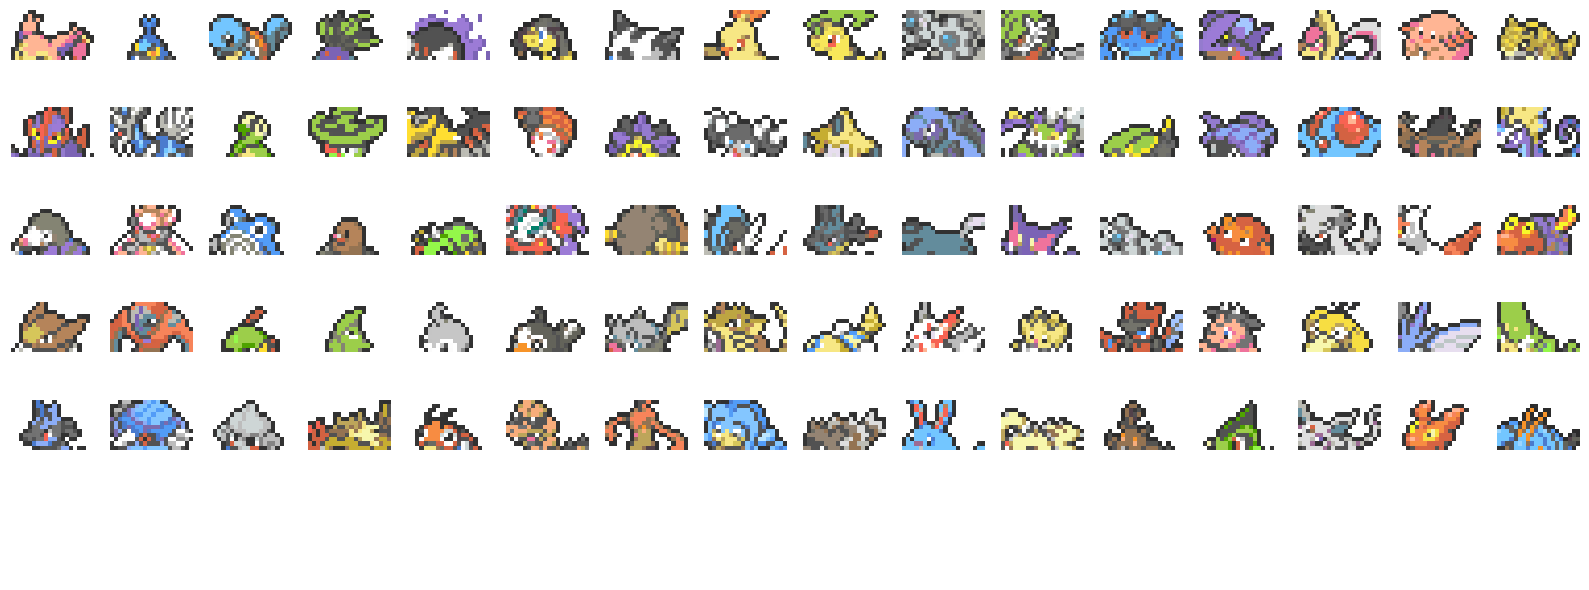

In [9]:
# Visualize test images
test_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["test"]]
show_images(test_images)

# Prepare Model

### Model Configuration
Here, we define the model configuration, including the architecture and key hyperparameters such as the number of attention heads, layers, embedding size, and more.
*   Hint 1: Adjust hyperparameters here for improved performance.
*   Hint 2: Experiment with different model architectures, such as Llama, Mistral, or Qwen, to enhance performance.
  * [LlamaConfig](https://huggingface.co/docs/transformers/model_doc/llama#transformers.LlamaConfig)
  * [MistralConfig](https://huggingface.co/docs/transformers/model_doc/mistral#transformers.MistralConfig)
  * [Qwen2Config](https://huggingface.co/docs/transformers/model_doc/qwen2#transformers.Qwen2Config)
  * [GPT2LMHeadModel](https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2LMHeadModel)

In [10]:
# medium level可調hyperparameters
# hard level可換model
# Define GPT-2 model configuration as a dictionary
#

# llama_config = LlamaConfig(
#     vocab_size=167,             # 不變，匹配像素值範圍
#     hidden_size=256,            # 減小至 256，減少過擬合（原 512）
#     intermediate_size=1024,     # 減至 1024，匹配 hidden_size 的 4 倍（原 2048）
#     num_hidden_layers=4,        # 減至 4 層，進一步減小容量（原 6）
#     num_attention_heads=4,      # 減至 4 頭，每頭維度 256/4=64（原 8）
#     num_key_value_heads=2,      # 減至 2，保持 GQA（原 4）
#     hidden_act="silu",          # 不變，SiLU 表現穩定
#     max_position_embeddings=512,# 不變，足以覆蓋 400
#     initializer_range=0.02,     # 不變，默認值合理
#     rms_norm_eps=1e-05,         # 不變，穩定性足夠
#     attention_dropout=0.4,      # 增至 0.2，加強正則化（原 0.1）
#     rope_theta=5000.0,         # 不變，序列長度合適
#     use_cache=True,             # 不變，推理加速
#     pad_token_id=166,           # 不變，匹配任務
#     bos_token_id=0,             # 不變
#     eos_token_id=1              # 不變
# )
#[目前次佳]
# gpt2_config = {
#     "activation_function": "silu",    # Activation function used in the model
#     "architectures": ["GPT2LMHeadModel"],  # Specifies the model type
#     "attn_pdrop": 0.05,            # Dropout rate for attention layers
#     "embd_pdrop": 0.05,            # Dropout rate for embeddings
#     "initializer_range": 0.05,        # Standard deviation for weight initialization
#     "layer_norm_epsilon": 1e-05,       # Small constant to improve numerical stability in layer norm
#     "model_type": "gpt2",           # Type of model
#     "n_ctx": 512,               # Context size (maximum sequence length)
#     "n_embd": 128,              # Embedding size
#     "n_head": 4,               # Number of attention heads
#     "n_layer": 6,              # Number of transformer layers
#     "n_positions": 512,           # Maximum number of token positions
#     "resid_pdrop": 0.05,           # Dropout rate for residual connections
#     "vocab_size": num_classes,       # Number of unique tokens in vocabulary
#     "pad_token_id": None,          # Padding token ID (None means no padding token)
#     "eos_token_id": None,          # End-of-sequence token ID (None means not explicitly defined)
# }

# LOSS rate 0.996 正確率下降幅度14% epo60
# LOSS rate 1.46 正確率下降幅度8.6%  epo50
# epco:50 目前次佳
# gpt2_config = {
#     "activation_function": "silu",    # Activation function used in the model
#     "architectures": ["GPT2LMHeadModel"],  # Specifies the model type
#     "attn_pdrop": 0.1,            # Dropout rate for attention layers
#     "embd_pdrop": 0.1,            # Dropout rate for embeddings
#     "initializer_range": 0.01,        # Standard deviation for weight initialization
#     "layer_norm_epsilon": 1e-05,       # Small constant to improve numerical stability in layer norm
#     "model_type": "gpt2",           # Type of model
#     "n_ctx": 512,               # Context size (maximum sequence length)
#     "n_embd": 128,              # Embedding size
#     "n_head": 4,               # Number of attention heads
#     "n_layer": 6,              # Number of transformer layers
#     "n_positions": 512,           # Maximum number of token positions
#     "resid_pdrop": 0.1,           # Dropout rate for residual connections
#     "vocab_size": num_classes,       # Number of unique tokens in vocabulary
#     "pad_token_id": None,          # Padding token ID (None means no padding token)
#     "eos_token_id": None,          # End-of-sequence token ID (None means not explicitly defined)
# }

#[qwen2]目前次佳
# qwen2_config = {
#     "architectures": ["Qwen2ForCausalLM"],  # Specifies the Qwen2 model type for causal language modeling
#     "model_type": "qwen2",                 # Type of model
#     "vocab_size": 167,                     # Number of unique pixel colors (classes) for Pokémon images
#     "hidden_size": 256,                    # Dimension of hidden representations (reduced from default 4096 for smaller task)
#     "intermediate_size": 1024,             # Dimension of MLP representations (scaled down from 22016)
#     "num_hidden_layers": 6,                # Number of transformer layers (aligned with GPT-2's n_layer for simplicity)
#     "num_attention_heads": 8,              # Number of attention heads (aligned with GPT-2's n_head)
#     "num_key_value_heads": 8,              # Set equal to num_attention_heads for Multi Head Attention (MHA)
#     "hidden_act": "silu",                  # Non-linear activation function (consistent with Qwen2 default)
#     "max_position_embeddings": 400,        # Maximum sequence length (20×20 = 400 pixels as tokens)
#     "initializer_range": 0.02,             # Standard deviation for weight initialization (same as GPT-2)
#     "rms_norm_eps": 1e-06,                # Epsilon for RMS normalization (Qwen2 default)
#     "use_cache": True,                     # Enable caching for generation (Qwen2 default)
#     "tie_word_embeddings": False,          # Input/output embeddings not tied (Qwen2 default)
#     "rope_theta": 10000.0,                # Base period for RoPE embeddings (Qwen2 default)
#     "rope_scaling": None,                  # No scaling for RoPE (default, as sequence length is manageable)
#     "use_sliding_window": False,           # Disable sliding window attention (not needed for short sequences)
#     "sliding_window": 400,                 # Set to sequence length if used (not applicable here)
#     "max_window_layers": 6,                # All layers use full attention (aligned with num_hidden_layers)
#     "attention_dropout": 0.1,             # Dropout for attention probabilities (aligned with GPT-2's attn_pdrop)
#     "bos_token_id": None,                  # No explicit beginning-of-sequence token for image tokens
#     "eos_token_id": None,                  # No explicit end-of-sequence token (aligned with GPT-2)
#     "pad_token_id": None,                  # No padding token (aligned with GPT-2)
# }

#[qwen2]目前最佳(穩定)
qwen2_config = {
    "architectures": ["Qwen2ForCausalLM"],  # 不變，保持因果語言模型
    "model_type": "qwen2",                 # 不變
    "vocab_size": 167,                     # 不變，匹配167類像素顏色
    "hidden_size": 512,                    # 從256增加到512，提升表示能力
    "intermediate_size": 2048,             # 從1024增加到2048，增強MLP容量
    "num_hidden_layers": 12,               # 從6增加到12，增強序列建模能力
    "num_attention_heads": 16,             # 從8增加到16，捕捉更細粒度依賴
    "num_key_value_heads": 16,             # 與num_attention_heads一致，保持MHA
    "hidden_act": "silu",                  # 不變，silu效果良好
    "max_position_embeddings": 400,        # 不變，匹配20×20序列
    "initializer_range": 0.02,             # 不變，初始化合理
    "rms_norm_eps": 1e-06,                # 不變，穩定性足夠
    "use_cache": True,                     # 不變，支持生成
    "tie_word_embeddings": False,          # 不變，保持靈活性
    "rope_theta": 10000.0,                # 不變，RoPE設置合適
    "rope_scaling": None,                  # 不變，400序列無需縮放
    "use_sliding_window": True,            # 從False改為True，啟用滑動窗口注意力
    "sliding_window": 100,                 # 設置為100，聚焦局部像素關係
    "max_window_layers": 10,               # 底層10層用滑動窗口，頂層2層用全注意力
    "attention_dropout": 0.2,              # 從0.1增加到0.2，增強正則化
    "bos_token_id": None,                  # 不變，無需特殊token
    "eos_token_id": None,                  # 不變
    "pad_token_id": None,                  # 不變
}





# [原始]
# gpt2_config = {
#     "activation_function": "gelu_new",    # Activation function used in the model
#     "architectures": ["GPT2LMHeadModel"],  # Specifies the model type
#     "attn_pdrop": 0.1,            # Dropout rate for attention layers
#     "embd_pdrop": 0.1,            # Dropout rate for embeddings
#     "initializer_range": 0.02,        # Standard deviation for weight initialization
#     "layer_norm_epsilon": 1e-05,       # Small constant to improve numerical stability in layer norm
#     "model_type": "gpt2",           # Type of model
#     "n_ctx": 128,               # Context size (maximum sequence length)
#     "n_embd": 64,              # Embedding size
#     "n_head": 2,               # Number of attention heads
#     "n_layer": 2,              # Number of transformer layers
#     "n_positions": 400,           # Maximum number of token positions
#     "resid_pdrop": 0.1,           # Dropout rate for residual connections
#     "vocab_size": num_classes,       # Number of unique tokens in vocabulary
#     "pad_token_id": None,          # Padding token ID (None means no padding token)
#     "eos_token_id": None,          # End-of-sequence token ID (None means not explicitly defined)
# }


# Load GPT-2 model configuration from dictionary
# config = GPT2Config.from_dict(gpt2_config)
config = Qwen2Config.from_dict(qwen2_config)
# config = LlamaForCausalLM(llama_config)

1. activation_function: "gelu_new"
意義：這個參數指定了模型中所使用的激活函數。gelu_new 是一種高效的激活函數，常用於Transformer類模型。它比ReLU更平滑，有助於更好的性能。

2. architectures: ["GPT2LMHeadModel"]
意義：這告訴我們模型的架構類型。在這裡，GPT2LMHeadModel表示模型是基於GPT-2架構，並且它是用來進行語言建模（Language Modeling）的，即預測序列中下一個詞。

3. attn_pdrop: 0.1
意義：這是模型中注意力層的dropout率。0.1表示有10%的概率會丟棄某些神經元來防止過擬合。這有助於增強模型的泛化能力。

4. embd_pdrop: 0.1
意義：這是嵌入層（Embedding layer）的dropout率，同樣的，這可以幫助防止過擬合。在這裡，10%的嵌入神經元將會被隨機丟棄。

5. initializer_range: 0.02
意義：這個參數定義了權重初始化的標準差。0.02表示模型的權重將以均勻分佈從[-0.02, 0.02]範圍內進行初始化。這有助於保證模型從合適的起點開始訓練。

6. layer_norm_epsilon: 1e-05
意義：這是一個小的常數，用於Layer Normalization操作中的分母，以避免數值不穩定。在此處設定為1e-05（0.00001），它能防止在計算中出現除以零的情況。

7. model_type: "gpt2"
意義：這告訴我們模型的具體類型是GPT-2。這是基於Transformer架構的一個自回歸模型，用於語言建模和文本生成。

8. n_ctx: 128
意義：這是上下文大小，也就是模型一次性可以處理的最大序列長度。在這裡設定為128，表示模型可以處理的最大詞元數是128。更長的上下文通常會讓模型理解更複雜的依賴關係。

9. n_embd: 64
意義：這是嵌入向量的維度，決定了詞元在嵌入層中被表示為多少維度的向量。在這裡，嵌入維度設為64。

10. n_head: 2
意義：這是注意力頭的數量。GPT-2模型使用多頭注意力機制，n_head = 2表示每層有2個注意力頭。增加注意力頭的數量可以讓模型捕捉到更多的語言特徵，但也會增加計算成本。

11. n_layer: 2
意義：這是Transformer層的數量，即有多少層堆疊的自注意力和前向網絡。在這裡，模型有2層。更多的層通常意味著模型更具表現力，但也會增加計算負擔。

12. n_positions: 400
意義：這是模型能夠處理的最大位置數量。在Transformer模型中，每個詞元會有一個位置編號，用來表示它在序列中的位置。n_positions = 400表示模型能處理最多400個詞元的位置。

13. resid_pdrop: 0.1
意義：這是殘差連接的dropout率，用於防止過擬合。設置為0.1表示在殘差連接（skip connection）上有10%的概率丟棄神經元。

14. vocab_size: num_classes
意義：這是詞彙表的大小，也就是模型可以處理的不同詞元的數量。num_classes應該是你數據集中的獨特詞元數量。每個詞元都會有一個唯一的ID，這些ID會映射到嵌入向量中。

15. pad_token_id: None
意義：這是填充令牌的ID，用於對齊不同長度的序列。如果沒有填充令牌，設置為None。

16. eos_token_id: None
意義：這是結束標誌令牌的ID，用來標識序列的結尾。如果模型不使用專門的結束標誌，則設置為None。

### Load Model

In [11]:
# Load the model using the configuration defined above
model = AutoModelForCausalLM.from_config(config)
# 返回model架構
print(model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# 返回有多少Trainable Parameters
print(f"Trainable Parameters: {trainable_params:,}")

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(167, 512)
    (layers): ModuleList(
      (0-11): 12 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (o_proj): Linear(in_features=512, out_features=512, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=512, out_features=2048, bias=False)
          (up_proj): Linear(in_features=512, out_features=2048, bias=False)
          (down_proj): Linear(in_features=2048, out_features=512, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((512,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((512,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((512,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbeddi

# Train and Inference

### Training Arguments
Here, we define the number of epochs for training, the learning rate, the optimizer, and the loss function.
*   Hint 3: Adjust the number of epochs and learning rate here to improve performance.

In [12]:
# modeium baseline可調epochs和learning rate
# Training Parameters
# epochs = 50
epochs = 100

# 1e-3 是科學記數法，表示 0.001，意味著每次參數更新時，模型的權重會根據梯度減少 0.001 倍。           # Number of training epochs
learning_rate = 1e-3
                        # Learning rate for optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")     # Check if CUDA is available for GPU
save_dir = "checkpoints"                               # Directory to save model checkpoints

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()                          # Loss function for classification tasks
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4) # AdamW optimizer with weight decay
# weight_decay=0.1

epochs = 50
意義：epochs 是訓練過程中遍歷整個訓練數據集的次數。設定為 50 表示模型將會在訓練數據上訓練 50 次（也就是經過 50 個完整的訓練週期）。

適合的任務：這個設定較為常見於中等規模的深度學習任務，尤其是數據集不過大（例如幾千到幾萬個樣本）。對於一些比較簡單的模型，這樣的設定可能已經足夠收斂，但對於較複雜的神經網絡或大量數據集，可能需要更多的訓練迭代次數，特別是如果模型在 50 次 epochs 下還沒完全收斂。

2. learning_rate = 1e-3
意義：學習率 (learning_rate) 控制模型每次參數更新的步伐大小。1e-3 即 0.001，這是常見的學習率，尤其是在使用如 Adam 等自適應優化器時。它表示模型每次更新參數時會根據計算出的梯度調整 0.001 的步長。

適合的任務：1e-3 是一個相對中等的學習率，適用於大多數深度學習任務。它能平衡訓練速度和收斂的穩定性。如果使用如 Adam、RMSprop 等優化器，這個學習率一般能有效地使模型逐步收斂。對於大多數中型數據集和深度學習模型（例如 CNNs、RNNs 等），這個學習率是合理的。

組合的含義和適用場景
適用任務：
中等難度的深度學習任務：例如圖像分類、語音識別、文本分類等，數據集的規模適中（例如數千到幾萬樣本）。對於這類任務，50 次 epoch 一般足夠進行有效的訓練，並且學習率 0.001 也能幫助模型在合理的時間內收斂。

使用自適應優化器（如 Adam）：如果你使用的優化器是 Adam 或 RMSprop，learning_rate = 1e-3 是一個常見的選擇，這些優化器會根據每個參數的梯度進行自動調整，減少過大學習率帶來的波動或不穩定性。

訓練過程：
訓練過程中，50 次 epoch 會讓模型有足夠的時間來學習數據中的模式，但如果是更複雜的問題或非常大的數據集，可能會需要更多的 epochs 來完全收斂。此時可以考慮使用 學習率衰減（Learning Rate Decay）來逐步減小學習率，以便在接近最優解時進行更精細的調整。

可能需要調整的地方：
如果訓練過程不穩定或收斂過慢：如果你發現模型的損失函數下降不穩定或收斂很慢，可以考慮減小學習率，比如設定為 1e-4 或 1e-5，或者增加 epoch 數量。

如果訓練過程過於快速且未能充分學習：如果訓練過程過於快速，並且模型的表現差，可能意味著學習率過大，可以嘗試將學習率設為較小的值（例如 1e-4），並觀察結果。
----
epochs：這取決於你的數據集和模型的表現，對於這樣的任務，通常會需要較多的訓練回合，可能會在50到100次之間。

learning rate：建議從較小的學習率（例如1e-4或1e-3）開始，並根據模型訓練的穩定性進行調整。

batch size：對於圖像生成問題，通常選擇的batch size較小（例如8或16），這樣可以減少顯存的使用，同時保持訓練的穩定性。

學習率的大小會影響到模型訓練的速度和效果：

如果學習率太大，模型可能會跳過最佳解，無法收斂，或者導致不穩定的訓練過程。

如果學習率太小，訓練過程會變得非常慢，且可能陷入局部最小值，無法達到全局最小值。

其他常見的學習率選項：
learning_rate = 1e-2：較大的學習率，訓練可能更快，但也有可能不穩定。

learning_rate = 1e-4：較小的學習率，訓練較為穩定，但可能需要更多的迭代才能收斂。

可以替換的學習率值：
learning_rate = 0.01：等同於 1e-2，較大的學習率。

learning_rate = 0.0001：等同於 1e-4，較小的學習率。

learning_rate = 0.0005：可以根據需要手動設置的學習率。

learning_rate = 1e-5：非常小的學習率，適用於對精度要求非常高的情況。

其他可能的學習率策略：
學習率衰減 (Learning Rate Decay)：隨著訓練進行，逐步降低學習率。

自適應學習率方法 (如 Adam, Adagrad, RMSprop)：這些方法會根據梯度的變化自動調整學習率。

---
學習率的大小通常需要與其他超參數和訓練設置相搭配進行調整，以達到最佳的訓練效果。調整學習率時，以下幾個因素會對訓練過程有影響：

1. 模型架構
簡單模型：例如線性回歸或小型的神經網絡，可能需要較大的學習率，因為這些模型通常比較簡單，容易訓練。

複雜模型：例如深層神經網絡（深度學習模型），可能需要較小的學習率，因為它們包含大量的參數，訓練過程較為複雜，需要更細緻的更新步伐以避免過度更新。

2. 批次大小 (Batch Size)
大批次大小：當使用較大的批次（例如，batch_size = 64 或更多），通常可以使用較大的學習率。這是因為大批次計算出來的梯度估計較為穩定，因此不太容易受到噪音的影響。

小批次大小：當批次比較小（例如，batch_size = 16 或更小）時，因為每次更新的梯度可能較為嘈雜，所以通常需要較小的學習率，以減少不穩定性。

3. 優化器 (Optimizer)
不同的優化器會影響學習率的選擇，某些優化器會自動調整學習率。例如：

SGD（隨機梯度下降）：在使用普通的隨機梯度下降（SGD）時，學習率的選擇相對較為關鍵。較大的學習率可能導致不穩定的訓練過程。

Adam / RMSprop / Adagrad：這些優化器可以自動調整每個參數的學習率，因此一般來說，可以使用較大的學習率（例如 0.001 或更大）。這些優化器基於參數的歷史梯度來調整學習率，使得學習過程更穩定。

4. 梯度的大小和訓練數據的特性
梯度的範圍：如果模型的梯度較大（例如，由於數據中包含極端值或某些特定的特徵），可能需要降低學習率來防止梯度爆炸（gradient explosion）。

數據規模和質量：如果訓練數據噪音較大或數據規模很大，可能需要適當減小學習率以使模型更穩定地收斂。

5. 訓練次數 (Epochs) 和早期停止 (Early Stopping)
訓練次數：如果你希望訓練更多的迭代次數來更好地收斂（例如 50~100 次訓練迴圈），可以考慮稍微提高學習率，以便快速進行初期的收斂。

早期停止 (Early Stopping)：如果使用了早期停止來避免過擬合，可能需要較小的學習率，以避免在收斂前過度波動。

6. 學習率衰減 (Learning Rate Decay)
在長時間訓練中，隨著模型接近最優解，學習率會逐漸減小。這樣可以讓模型在達到收斂時更加精確。學習率衰減可以搭配以下策略使用：

階段性衰減：例如每訓練若干次 epoch，就將學習率減少一半。

指數衰減：學習率會按照一定的指數函數衰減。

學習率預熱 (Warmup)：在訓練初期，學習率較低，逐步增大，然後再衰減。

7. 損失函數和問題的性質
平滑的損失函數：如果損失函數比較光滑，學習率可以相對較大。

不光滑的損失函數：如果損失函數不光滑（例如在深度學習中可能出現的鞍點或局部最小值），則學習率應該較小，以避免錯過最佳解。

8. 驗證集的表現
訓練過程中，可以根據在驗證集上的表現來動態調整學習率。如果模型在驗證集上的損失停滯不前，可以考慮減小學習率以進一步精細調整。

如何搭配調整：
學習率與優化器配合：如果使用 Adam 或其他自適應優化器，可以嘗試較大的學習率（例如 0.001），並根據結果進行微調。如果使用 SGD，則需要較小的學習率（例如 0.01 或更小）。

學習率與批次大小配合：大批次大小配合較大的學習率，小批次大小則配合較小的學習率。

### Save Model Function

In [13]:
def save_model(model: torch.nn.Module, optimizer: torch.optim.Optimizer, epoch: int, loss: float, save_dir: str, filename: str = "best_model.pth") -> None:
    """
    Saves the model state, optimizer state, current epoch, and loss to a specified directory.

    Args:
        model (torch.nn.Module): The PyTorch model to be saved.
        optimizer (torch.optim.Optimizer): The optimizer whose state will be saved.
        epoch (int): The current epoch number (used for checkpointing).
        loss (float): The current loss value to track model performance.
        save_dir (str): The directory where the model checkpoint will be saved.
        filename (str, optional): The name of the file to save the model. Defaults to "best_model.pth".

    Returns:
        None
    """
    # Construct the full path for saving the model checkpoint
    save_path = os.path.join(save_dir, filename)

    # Save the model, optimizer state, and additional metadata (epoch and loss)
    torch.save({
        'epoch': epoch + 1,                # Save epoch + 1 for easier tracking
        'model_state_dict': model.state_dict(),       # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state (important for resuming training)
        'loss': loss                     # Save the current loss value
    }, save_path)

    # Print a confirmation message indicating the model has been saved
    print(f"Model saved at {save_path} (Loss: {loss:.4f}, Epoch: {epoch + 1})")

### Train

We save the checkpoint with the lowest training loss since validation set reconstruction accuracy doesn't directly reflect the model's image generation quality.
*   Hint 4: Train a classifier to check if an image looks like a Pokémon or not. (Optional)

In [14]:
# 可做:Train a classifier to check if an image looks like a Pokémon or not. (Optional)
# 訓練
# Create save directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
# Initialize best loss as positive infinity for comparison during model checkpointing
best_loss: float = float('inf')
# Move model to the appropriate device (GPU or CPU)
model.to(device)

# Training Loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize the epoch loss

    # Iterate over training data batches
    for input_ids, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        input_ids, labels = input_ids.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass through the model to get logits (output probabilities)
        outputs = model(input_ids=input_ids).logits.view(-1, config.vocab_size)
#llama        # outputs = model(input_ids=input_ids).logits.view(-1, llama_config.vocab_size)
        labels = labels.view(-1)  # Flatten labels to match logits shape

        # Calculate loss using CrossEntropyLoss
        loss = criterion(outputs, labels)

        # Backpropagation and optimizer step
        optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()     # Compute gradients
        optimizer.step()     # Update model weights

        # Accumulate the loss for the epoch
        epoch_loss += loss.item()

    # Compute average epoch loss
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

    #評估
    # Evaluation Loop (Validation)
    model.eval()      # Set the model to evaluation mode (disables dropout, etc.)
    total_accuracy = 0  # Initialize total accuracy
    num_batches = 0   # Initialize batch counter

    with torch.no_grad():  # Disable gradient calculation for validation
        # Iterate over validation data batches
        for inputs, labels in tqdm(dev_dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move validation data to device
            attention_mask = torch.ones_like(inputs)          # Attention mask to ensure valid token positions

            # Perform batch inference using the model
            generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

            # Extract the last 160 tokens from generated outputs and labels
            generated_outputs = generated_outputs[:, -160:]

            # Calculate accuracy for the batch
            accuracy = (generated_outputs == labels).float().mean().item()
            total_accuracy += accuracy
            num_batches += 1

    # Compute average reconstruction accuracy for the epoch
    avg_accuracy = total_accuracy / num_batches
    print(f"Epoch {epoch + 1}/{epochs}, Reconstruction Accuracy: {avg_accuracy:.4f}")
    #把最低的traing loss當check point標準
    # If the current epoch loss is better (lower) than the best loss, save the model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss                   # Update best loss
        save_model(model, optimizer, epoch, best_loss, save_dir)  # Save the model with the best loss

Training Epoch 1/120: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Epoch 1/120, Loss: 3.4027


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.41s/it]


Epoch 1/120, Reconstruction Accuracy: 0.3740
Model saved at checkpoints/best_model.pth (Loss: 3.4027, Epoch: 1)


Training Epoch 2/120: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


Epoch 2/120, Loss: 2.7867


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


Epoch 2/120, Reconstruction Accuracy: 0.3694
Model saved at checkpoints/best_model.pth (Loss: 2.7867, Epoch: 2)


Training Epoch 3/120: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


Epoch 3/120, Loss: 2.1753


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


Epoch 3/120, Reconstruction Accuracy: 0.3731
Model saved at checkpoints/best_model.pth (Loss: 2.1753, Epoch: 3)


Training Epoch 4/120: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


Epoch 4/120, Loss: 1.8086


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.40s/it]


Epoch 4/120, Reconstruction Accuracy: 0.3438
Model saved at checkpoints/best_model.pth (Loss: 1.8086, Epoch: 4)


Training Epoch 5/120: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


Epoch 5/120, Loss: 1.6157


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


Epoch 5/120, Reconstruction Accuracy: 0.2690
Model saved at checkpoints/best_model.pth (Loss: 1.6157, Epoch: 5)


Training Epoch 6/120: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


Epoch 6/120, Loss: 1.4925


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.40s/it]


Epoch 6/120, Reconstruction Accuracy: 0.3001
Model saved at checkpoints/best_model.pth (Loss: 1.4925, Epoch: 6)


Training Epoch 7/120: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


Epoch 7/120, Loss: 1.4071


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


Epoch 7/120, Reconstruction Accuracy: 0.3438
Model saved at checkpoints/best_model.pth (Loss: 1.4071, Epoch: 7)


Training Epoch 8/120: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


Epoch 8/120, Loss: 1.3420


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.41s/it]


Epoch 8/120, Reconstruction Accuracy: 0.3300
Model saved at checkpoints/best_model.pth (Loss: 1.3420, Epoch: 8)


Training Epoch 9/120: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


Epoch 9/120, Loss: 1.2874


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


Epoch 9/120, Reconstruction Accuracy: 0.3525
Model saved at checkpoints/best_model.pth (Loss: 1.2874, Epoch: 9)


Training Epoch 10/120: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


Epoch 10/120, Loss: 1.2323


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.41s/it]


Epoch 10/120, Reconstruction Accuracy: 0.3437
Model saved at checkpoints/best_model.pth (Loss: 1.2323, Epoch: 10)


Training Epoch 11/120: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


Epoch 11/120, Loss: 1.1784


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.40s/it]


Epoch 11/120, Reconstruction Accuracy: 0.3430
Model saved at checkpoints/best_model.pth (Loss: 1.1784, Epoch: 11)


Training Epoch 12/120: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


Epoch 12/120, Loss: 1.1350


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.43s/it]


Epoch 12/120, Reconstruction Accuracy: 0.3622
Model saved at checkpoints/best_model.pth (Loss: 1.1350, Epoch: 12)


Training Epoch 13/120: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


Epoch 13/120, Loss: 1.0897


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.41s/it]


Epoch 13/120, Reconstruction Accuracy: 0.3586
Model saved at checkpoints/best_model.pth (Loss: 1.0897, Epoch: 13)


Training Epoch 14/120: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


Epoch 14/120, Loss: 1.0179


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.44s/it]


Epoch 14/120, Reconstruction Accuracy: 0.3689
Model saved at checkpoints/best_model.pth (Loss: 1.0179, Epoch: 14)


Training Epoch 15/120: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


Epoch 15/120, Loss: 0.9687


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.40s/it]


Epoch 15/120, Reconstruction Accuracy: 0.3652
Model saved at checkpoints/best_model.pth (Loss: 0.9687, Epoch: 15)


Training Epoch 16/120: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


Epoch 16/120, Loss: 0.9153


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


Epoch 16/120, Reconstruction Accuracy: 0.3324
Model saved at checkpoints/best_model.pth (Loss: 0.9153, Epoch: 16)


Training Epoch 17/120:  62%|██████▎   | 25/40 [00:21<00:12,  1.18it/s]


KeyboardInterrupt: 

### Inference

In [ ]:
#把model load進來做evaluate，生成prediction file
# Load the best model from the saved checkpoint
best_model_path = os.path.join(save_dir, "best_model.pth")              # Path to the best model checkpoint
checkpoint = torch.load(best_model_path, weights_only=True, map_location=device)  # Load checkpoint from the file
model.load_state_dict(checkpoint["model_state_dict"])                  # Load the model weights from checkpoint
model.eval()                                        # Set the model to evaluation mode (disables dropout, etc.)

# Testing Loop with Batch Inference
results: list = []  # List to store the generated sequences from the model

with torch.no_grad():  # Disable gradient calculations for inference
    # Iterate over test data in batches
    for inputs in tqdm(test_dataloader, desc="Generating Outputs"):
        inputs = inputs.to(device)         # Move model to the appropriate device (GPU or CPU)
        attention_mask = torch.ones_like(inputs)  # Attention mask (ensure valid token positions)

        # Generate predictions for the entire batch
        generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

        # Convert batch outputs to a list and append to results
        batch_results = generated_outputs.cpu().numpy().tolist()
        results.extend(batch_results)  # Extend the results list with batch results

# Save the results to a file
output_file: str = "reconstructed_results.txt"  # File to save the output sequences
with open(output_file, "w") as f:
    # Write each sequence to the file
    for seq in results:
        f.write(" ".join(map(str, seq)) + "\n")

print(f"Reconstructed results saved to {output_file}")  # Confirmation message

In [ ]:
# 查看生成後的圖片
# Visualize generated test images
predicted_images = [pixel_to_image(sequence, colormap) for sequence in results]
show_images(predicted_images)